In [1]:
import orcapod as op
from demo_setup.config import namespace_lookup, data_dir, store_dir, orch, client
import demo_setup.util as demo_util

## Orcapod DEMO

A framework for fully traceable and reproducible scientific computation

## Guiding Principles

- Reproducibility
- Performance
- Simplicity
- Flexibility
- Extensibility
- Reusability
- Robustness


## Monitors


In [ ]:
# monitor active containers

# watch -n 0.5 docker ps -a

## Setup test inputs


- `data_lake/models`: Painting style models used as input



In [4]:
!ls -1 ../data_lake/models

mosaic.t7
starry_night.t7


- `data_lake/subjects`: Subject images used as input

In [3]:
demo_util.display_images("../data_lake/subjects")


## Define computation


`style_transfer_pod` - Python computation that:

- Reads a subject image
- Reads a painting style model
- Generates a new image that applies painting style to subject image
- Sleeps randomly between 0 - 10 seconds


In [5]:
from textwrap import dedent

In [6]:
style_transfer_pod = op.Pod(
    image="demisto/opencv:1.0.0.4855524",
    command=[
        "bash",
        "-c",
        "umask u=rwx,g=rwx,o=rwx && python -c '{}'".format(
            dedent(
                """
                import os
                import cv2
                import numpy as np
                import imutils
                from time import sleep
                from random import randint

                sleep(randint(0, 10))

                with open("/input/subject.jpeg", "rb") as f:
                    image = f.read()

                net = cv2.dnn.readNetFromTorch("/input/model.t7")
                prepared_image = np.frombuffer(image, np.uint8)
                prepared_image = cv2.imdecode(prepared_image, cv2.IMREAD_COLOR)

                prepared_image = imutils.resize(prepared_image, width=600)
                (h, w) = prepared_image.shape[:2]

                # construct a blob from the image, set the input, and then perform a
                # forward pass of the network
                blob = cv2.dnn.blobFromImage(prepared_image, 1.0, (w, h),
                    (103.939, 116.779, 123.680), swapRB=False, crop=False)
                net.setInput(blob)
                output = net.forward()

                # reshape the output tensor, add back in the mean subtraction, and
                # then swap the channel ordering
                output = output.reshape((3, output.shape[2], output.shape[3]))
                output[0] += 103.939
                output[1] += 116.779
                output[2] += 123.680
                output = output.transpose(1, 2, 0)
                output = np.clip(output, 0, 255)
                output= output.astype("uint8")

                with open("/output/image.jpeg", "wb") as f:
                    f.write(cv2.imencode(".jpeg", output)[1].tobytes())

                print("done!")
                """
            ).strip()
        ),
    ],
    input_spec={
        "subject": op.PathInfo(path="/input/subject.jpeg", match_pattern=".*\.jpeg"),
        "model": op.PathInfo(path="/input/model.t7", match_pattern=".*\.t7"),
    },
    output_dir="/output",
    output_spec={"image": op.PathInfo(path="image.jpeg", match_pattern=".*\.jpeg")},
    source_commit_url="https://place.holder",
    recommended_cpus=1.0,
    recommended_memory=1 << 30,
)

`flip_pod` - Bash computation that:

- Reads an image
- Generates a horizontally flipped image


In [7]:
flip_pod = op.Pod(
    image="dpokidov/imagemagick:7.1.1-47",
    command="magick /input/image.jpeg -flop /output/flipped_image.jpeg".split(" "),
    input_spec={
        "image": op.PathInfo(path="/input/image.jpeg", match_pattern=".*\.jpeg")
    },
    output_dir="/output",
    output_spec={
        "flipped_image": op.PathInfo(
            path="flipped_image.jpeg", match_pattern=".*\.jpeg"
        )
    },
    source_commit_url="https://place.holder",
    recommended_cpus=0.1,
    recommended_memory=100 << 20,
)

## Define computational pipeline


A simple compute pipeline that chains a `style_transfer_pod` computation to a `flip_pod` computation.


In [8]:
pipeline = op.Pipeline(
    graph_dot="""
    digraph {
        style_transfer -> flip
    }
    """,
    metadata={
        "style_transfer": op.Kernel.POD(ref=style_transfer_pod),
        "flip": op.Kernel.POD(ref=flip_pod),
    },
    input_spec={
        "subject": [op.InputSpecUri(node="style_transfer", key="subject")],
        "model": [op.InputSpecUri(node="style_transfer", key="model")],
    },
    output_spec={"resultant_image": op.OutputSpecUri(node="flip", key="flipped_image")},
)

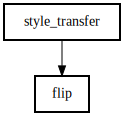

In [9]:
demo_util.display_dot(dot_data=pipeline.make_dot())

## Run computational pipeline job


In [10]:
from datetime import datetime, timezone

In [11]:
pipeline_job = op.PipelineJob(
    pipeline=pipeline,
    input_packet={
        "subject": [
            op.PathSet.UNARY(
                blob=op.Blob(
                    kind=op.BlobKind.FILE,
                    location=op.Uri(
                        namespace="default",
                        path=path,
                    ),
                    checksum="",
                )
            )
            for path in (
                "subjects/dog.jpeg",
                "subjects/cat.jpeg",
                "subjects/pyramid.jpeg",
            )
        ],
        "model": [
            op.PathSet.UNARY(
                blob=op.Blob(
                    kind=op.BlobKind.FILE,
                    location=op.Uri(
                        namespace="default",
                        path=path,
                    ),
                    checksum="",
                )
            )
            for path in ("models/mosaic.t7", "models/starry_night.t7")
        ],
    },
    output_dir=op.Uri(namespace="default", path=f"{data_dir}/style_transfer_pipeline"),
    namespace_lookup=namespace_lookup,
)

In [12]:
pipeline_run = await client.start_pipeline_job(pipeline_job=pipeline_job)

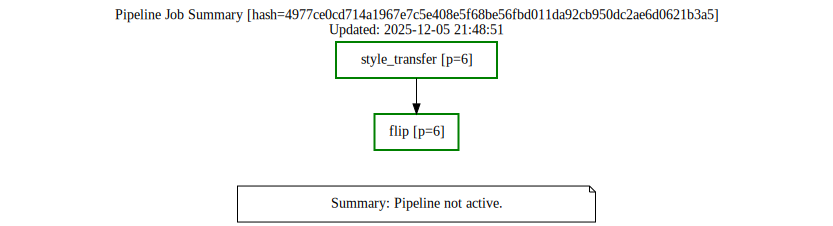

In [13]:
demo_util.animate_display(
    next_display_object=lambda: (
        demo_util.display_dot(dot_data=pipeline_run.summarize_dot())
        if not pipeline_run.terminated()
        or datetime.now(timezone.utc).timestamp() <= pipeline_run.terminated() + 2
        else None
    )
)

In [14]:
pipeline_result = await client.get_pipeline_result(pipeline_run=pipeline_run)

In [16]:
{
    "created": pipeline_result.created,
    "status": pipeline_result.status,
    "terminated": pipeline_result.terminated,
}

{'created': 1764971318,
 'status': <PipelineStatus.COMPLETED: 0>,
 'terminated': 1764971330}

In [15]:
demo_util.display_images("../data_lake/subjects")
demo_util.display_images("../data_lake/data/style_transfer_pipeline/flip")

## Roadmap

- Educational / Pitching Content
- Simpler, python-friendly experience
- Pipeline of pipelines
- Kubernetes orchestrator
- Queries and data exploration
- Dashboard GUIs
- Multi-agent support
- Tags
- Memoization
- Filter operator
- Agent resource limits
- Support external extensibility


## Teardown


In [ ]:
import shutil
from pathlib import Path

In [ ]:
shutil.rmtree(Path(namespace_lookup["default"]) / store_dir)
shutil.rmtree(Path(namespace_lookup["default"]) / data_dir)

In [ ]:
# restart kernel between notebooks to shutdown active agent